# Recommender Systems
- Recommender systems play a pivotal role in many online platforms, enabling users to discover new content or product tailored to their preferences.
- Among the various techniques for building recommendation systems, collaborative filtering stands out as a widely adopted approach.
- This notebook contains collaborative filtering, matrix factorization and the assessment of recommendation systems.

### Loading and Preprocessing the Data

In [1]:
# importing lbraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings

In [2]:
# configuring the notebook
pd.set_option("display.max_columns", None)
sns.set_theme(style = "whitegrid")
warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = (20, 5)

In [3]:
# loading the data
movies = pd.read_csv("movies.csv")
ratings = pd.read_csv("ratings.csv")
users = pd.read_csv("users.csv")

In [4]:
print(movies.shape)
movies.head()

(10329, 3)


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
print(ratings.shape)
ratings.head()

(105339, 4)


,userId,movieId,rating,timestamp
0,1,16,4.0,1217897793
1,1,24,1.5,1217895807
2,1,32,4.0,1217896246
3,1,47,4.0,1217896556
4,1,50,4.0,1217896523


In [6]:
print(users.shape)
users.head()

(668, 3)


,userId,age,time_spent_per_day
0,1,16,3.976315
1,2,24,1.891303
2,3,20,4.521478
3,4,23,2.095284
4,5,35,1.759860


Selecting the data with most frequently rated movies by counting the number of ratings for each movie and selecting the top 1000 movies with the highest rating counts.

In [7]:
# ratings of top 1000 movies
select_movies = ratings["movieId"].value_counts().head(1000).index.to_list()
# filtering if the movie is in the top 1000 movies
movies = movies.loc[movies["movieId"].isin(select_movies)]
# ratings of top 1000 movies
ratings = ratings.loc[ratings["movieId"].isin(select_movies)]

In [8]:
movies.shape

(1000, 3)

In [9]:
ratings.shape

(63250, 4)

### Transforming Movie Genres into Binary Features
- The following transformation of data is done in order to prepare it for use in recommendation system.
- A structured dataset is created by representing genres as binary features (1 if a movie belongs to a genre and 0 if otherwise), this is more suitable for training recommendation models.
- This transformation simplifies the data and allows in quantifying the presence or absence of a specific genre for each movie. This makes it easier to identify genre preferences and similarities among users and movies.

In [10]:
# creating a sparse matrix with movieId as rows and genres as columns
m = movies.copy()
m["genres"] = m["genres"].str.split("|")
m = m.explode("genres")
m = m.pivot(index = "movieId", columns = "genres", values = "title")
m = ~m.isna()
m = m.astype(int)
m.head()

genres,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieId,,,,,,,,,,,,,,,,,,,
1,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0


### Extracting Hour from Timestamp
- Extracting the hour from the timestamp can searve as a valuable user feature.
- By incorporating the hour of the day in which the users rated movies, helps in capturing the time based patterns and behaviors of the users.

In [11]:
r = ratings.copy()
r["hour"] = r["timestamp"].apply(lambda x: datetime.fromtimestamp(x).hour)
r.head()

,userId,movieId,rating,timestamp,hour
0,1,16,4.0,1217897793,6
1,1,24,1.5,1217895807,5
2,1,32,4.0,1217896246,6
3,1,47,4.0,1217896556,6
4,1,50,4.0,1217896523,6


### Merging User Data with Aggregated Statistics from Ratings
This adds features for each user's average rating and the average hour of rating submission, enhancing user profiles for recommendation systems.

In [12]:
users = users.merge(r.groupby("userId")["rating"].mean().reset_index(), on = "userId")
users = users.merge(r.groupby("userId")["hour"].mean().reset_index(), on = "userId")
users.head()

,userId,age,time_spent_per_day,rating,hour
0,1,16,3.976315,3.691589,5.616822
1,2,24,1.891303,3.923077,21.000000
2,3,20,4.521478,3.806452,14.370968
3,4,23,2.095284,4.159420,8.000000
4,5,35,1.759860,2.864865,0.513514


# How can this Information be used to Build a Regressor?
### What is the target variable?
"**rating**" is the target variable.

### What should the features be?
users: userId, age, time_spent_per_day, avg_hour, avg_rating

ratings: movie_id

movies: Action, Adventure, Animation, Children, Comedy, Crime, Documentary, Drama, Fantasy, Film-Noir, Horror, IMAX, Musical, Mystery, Romance, Sci-Fi, Thriller, War Western

The above features from the respective DataFrame will be used to build the regressor model.

In [13]:
# rescaling the data
u = users.copy()
u = u.set_index("userId")
u.columns = ["age", "time_spent_per_day", "u_avg_rating", "hour"]

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
u = pd.DataFrame(scaler.fit_transform(u), columns = u.columns, index = u.index)
u.head()

,age,time_spent_per_day,u_avg_rating,hour
userId,,,,
1,-1.470292,0.341073,-0.073572,-0.882006
2,-0.135616,-1.079947,0.426461,1.477906
3,-0.802954,0.712624,0.174541,0.460955
4,-0.302450,-0.940926,0.936982,-0.516406
5,1.699565,-1.169532,-1.859363,-1.664898


In [14]:
m.head()

genres,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieId,,,,,,,,,,,,,,,,,,,
1,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0


In [15]:
r.head()

,userId,movieId,rating,timestamp,hour
0,1,16,4.0,1217897793,6
1,1,24,1.5,1217895807,5
2,1,32,4.0,1217896246,6
3,1,47,4.0,1217896556,6
4,1,50,4.0,1217896523,6


In [16]:
u.head()

,age,time_spent_per_day,u_avg_rating,hour
userId,,,,
1,-1.470292,0.341073,-0.073572,-0.882006
2,-0.135616,-1.079947,0.426461,1.477906
3,-0.802954,0.712624,0.174541,0.460955
4,-0.302450,-0.940926,0.936982,-0.516406
5,1.699565,-1.169532,-1.859363,-1.664898


# Creating Final Feature Matrix
- Creating a merged DataFrame "X" by combining user and movie data with their respective ratings.
- Selectin columns movieId, userId and rating from the ratings dataset, then merging this data with user information and movie information based on userId and movieId respectively.
- The result is a combined dataset that includes user and movie attributes along with their ratings, providing a comprehensive basis for building a recommendation model.

In [17]:
X = ratings[["movieId", "userId", "rating"]].copy()
X = X.merge(u.reset_index(), on = "userId", how = "right")
X = X.merge(m.reset_index(), on = "movieId", how = "right")
X.head()

,movieId,userId,rating,age,time_spent_per_day,u_avg_rating,hour,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,2,5.0,-0.135616,-1.079947,0.426461,1.477906,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,1,5,4.0,1.699565,-1.169532,-1.859363,-1.664898,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,1,8,5.0,0.364888,0.298545,0.160605,1.324497,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,1,11,4.0,-1.303458,0.513712,-0.380602,0.557454,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,1,14,4.0,-0.302450,1.251552,-0.379415,0.557454,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [18]:
X = X.drop(columns = ["movieId", "userId"])
y = X.pop("rating")

In [19]:
X.head()

,age,time_spent_per_day,u_avg_rating,hour,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,-0.135616,-1.079947,0.426461,1.477906,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,1.699565,-1.169532,-1.859363,-1.664898,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0.364888,0.298545,0.160605,1.324497,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,-1.303458,0.513712,-0.380602,0.557454,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,-0.302450,1.251552,-0.379415,0.557454,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [20]:
y.head()

0    5.0
1    4.0
2    5.0
3    4.0
4    4.0
Name: rating, dtype: float64

In [21]:
# performing train test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Building the Regression Model

In [22]:
from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

MSE is a better choice for recommendation systems with discrete and bounded ratings.

In [23]:
from sklearn.metrics import mean_squared_error as mse

mse(y_test, y_pred) ** 0.5

0.8868670385241071

The rating is off by 0.88 units on average. Maybe this can be better.

# Does Cold Start Problem occur with this Model?
Can the ratings still be predicted even if a new user and movie are added? Yes, because user based information like "u_avg_rating" and "hour" are required. Meaning the rating prediction model is designed to incorporate additional factors beyond just the user-item interactions.

The above statement tranlates to,
1. Prediction Persistence: The model is capable of predicting ratings for new users and movies, even if they were not part of the original training data. This implies that the model has learned generalizable patterns about user preferences and movie characteristics.
2. User-Based Information: The statement mentions that "user-based information" like u_avg_rating and hour is required. This indicates that the model leverages information about the user's overall rating behavior and the time of day when the rating was given to improve prediction accuracy.

In [24]:
# ratings for user 1
ratings.loc[ratings["userId"] == 1].head()

,userId,movieId,rating,timestamp
0,1,16,4.0,1217897793
1,1,24,1.5,1217895807
2,1,32,4.0,1217896246
3,1,47,4.0,1217896556
4,1,50,4.0,1217896523


In [25]:
# predicting what rating would user 1 give to movie 16 (watched by user 1)
model.predict(pd.concat([u.loc[1], m.loc[16]]).values.reshape(1, -1))

array([4.04005118])

This is very close to the actual rating that the user 1 gave for movie 1.

In [26]:
# predicting what rating would user 1 give to movie 1 (unwatched by user 1)
model.predict(pd.concat([u.loc[1], m.loc[1]]).values.reshape(1, -1))

array([3.71729074])

A regression model has been built to predict the ratings based on user and movie features. But this is not an efficient method of building a recommendation system for the following reasons,
1. Data Sparsity:
    - Recommender systems often deal with sparse user-item interaction data.
    - Regression models require data for each user-item pair to make predictions.
    - However, most of the users have not interacted with most items, leading to lack of data for training the model for many user-item pairs.
    - This can result in a high number of missing values in the dataset, making it challenging for regression models to generalize effectively.
2. Cold Start Problem: Regression models struggle with the cold start problem when a new user or otem with limited interaction history are introduced to the system.
3. Limited Latent Factor Capture:
    - Regression models rely solely on explicit user and item features to make predictions.
    - They may not effectively capture latent factors or hidden patterns that significantly influence user-item interactions.
    - This can result in less accurate recommendations compared to matrix factorization, which inherently captures latent factors.

# Collaborative Filtering
Collaborative filtering is a recommendation methodology designed to make predictions (filtering) about a user's interests by aggregating and analyzing preferences from a collective of users (collaborative). The core idea behind this approach is that users who have shared preferences in the past are likely to have shared preferences in the future.
- If two users like the same movies they are similar.
- If two movies are liked by the same users they are similar.

Note that instead of "two", similarity is approximated by as many data points as possible. Popular movies may be liked by everyone, but that does not mean that they are similar.

This is hard to achieve because there are simultaneous interactions. Meaning, users often interact with multiple items at the same time (e.g., watching multiple movies or listening to multiple songs). This can make it difficult to accurately determine the individual influence of each item on a user's preferences.

One of the methods to deal with sparsity is matrix factorization.

# Matrix Factorization
Matrix factorization is a mathematical technique commonly used in recommendation systems to factorize a user-item interaction matrix into a lower dimensional matrices representing users and items.

The core concept behind matrix factorization is to approximate the original matrix by decomposing it into 2 or more matrices, such that the product of them results in the original matrix. This process helps uncover latent factors that influence user-item interactions.

# Breakdown of the Process of Matrix Factorization
1. User-Item Interaction Matrix:

    - In recommendation systems, the start point is the user-item interaction matrix, often denoted as R.
    - Rows correspond to users, columns correspond to items, and the entries R_ij represent the user ratings, interactions, or preferences for the items
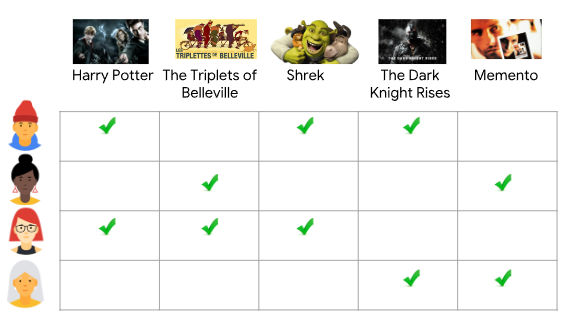
2. Decomposition:
    - Matrix factorization decomposes this user-item interaction matrix R into two lower dimensional matrices, typically denoted as U (user matrix) and I (item matrix).
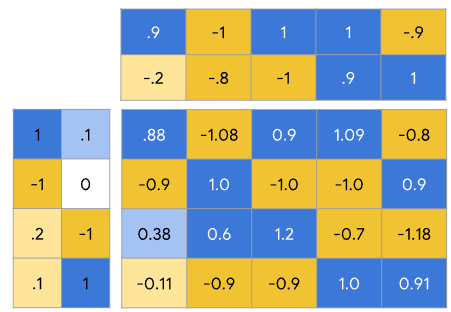
3. Dimensions:
    - The dimensions of the user matrix U are `mxk`, where `m` is the number of users, and `k` is the number of latent factors. The item matrix I has the dimensions of `kxn`, where `n` is the number of items.
4. Objective Function:
    - The goal of matrix factorization is to find the matrices U and V such that the product U * V approximates the original matrix R.
    - To achieve this, an objective function is defined, often using a loss function like Mean Squared Error (MSE) or a variant of it.
    - $Loss = 𝚺 (R_{ij}-(U_{i}*I_{j}))^{2}$
    - Here, U_i and I_j are the latent factor vectors for the i-th user and j-th item, respectively.
5. Optimization:
    - The matrices U and I are optimized to minimize the loss function. This is typically done using optimization techniques like gradient descent or alternating least square (ALS).
    - Here, gradient descent is used to optimize the loss function.
    - $\theta = \theta - 2 * \frac{∂L}{∂\theta}$
    - The optimization process updates the latent factor vectors in U and I iteratively to improve the approximation of the original matrix R.
    - The objective is to find U and V that provide the best fit to the observed user-item interactions.
6. Prediction:
    - Once the optimization is complete, the factorized matrices U and I can be used to predict missing values in the original matrix R.
    - These predictions are used to generate recommendations for users.

In [27]:
# considering the ratings data
ratings.head()

,userId,movieId,rating,timestamp
0,1,16,4.0,1217897793
1,1,24,1.5,1217895807
2,1,32,4.0,1217896246
3,1,47,4.0,1217896556
4,1,50,4.0,1217896523


Converting the original user-item interaction data into a user-item matrix where rows represent users, columns represent movies, and the entries contain user ratings. Any missing values (i.e., unrated movies) are filled with 0, creating a matrix suitable for collaborative filtering in recommendation systems.

In [28]:
rm = ratings.pivot(index = "userId", columns = "movieId", values = "rating").fillna(0)
rm.head()

movieId,1,2,3,5,6,7,10,11,16,17,19,21,22,24,25,29,31,32,34,36,39,44,45,47,48,50,52,58,62,65,70,88,95,104,105,107,110,111,112,135,141,145,150,151,153,158,160,161,163,165,168,170,172,173,175,180,185,186,193,194,196,198,204,208,216,223,224,225,230,231,232,235,236,246,247,252,253,256,260,261,265,266,272,273,277,282,288,292,293,296,300,303,306,307,308,315,316,317,318,319,327,329,333,337,339,342,344,345,348,349,350,353,355,356,357,361,364,367,368,370,372,376,377,379,380,383,410,412,413,419,420,431,432,434,435,440,441,442,454,455,457,466,468,471,474,475,480,485,494,497,500,508,509,515,520,524,527,529,531,539,541,543,546,551,552,553,555,562,585,586,587,588,589,590,592,593,594,595,596,597,608,610,616,628,647,648,653,661,671,673,708,719,720,724,733,736,741,743,745,750,762,778,780,783,784,785,786,788,799,800,802,805,832,837,838,849,852,858,866,880,898,899,902,903,904,908,909,910,912,913,914,916,919,920,922,923,924,926,933,953,954,968,969,996,1020,1022,1027,1028,1029,1032,1035,1036,1037,1041,1042,1047,1049,1059,1060,1061,1073,1077,1079,1080,1084,1086,1088,1089,1090,1092,1093,1094,1095,1097,1100,1101,1103,1104,1120,1125,1127,1129,1136,1148,1172,1175,1179,1183,1186,1188,1193,1196,1197,1198,1199,1200,1201,1203,1204,1206,1207,1208,1210,1212,1213,1214,1215,1217,1219,1220,1221,1222,1223,1225,1228,1230,1231,1233,1234,1235,1237,1240,1242,1244,1245,1246,1247,1249,1250,1252,1253,1256,1258,1259,1261,1262,1263,1265,1266,1267,1269,1270,1271,1272,1274,1275,1276,1278,1282,1283,1284,1285,1287,1288,1291,1293,1296,1298,1299,1302,1304,1307,1320,1321,1333,1339,1343,1345,1347,1356,1357,1358,1367,1370,1371,1372,1373,1374,1375,1376,1377,1378,1380,1385,1387,1391,1393,1394,1396,1405,1407,1408,1409,1411,1416,1438,1466,1476,1479,1485,1499,1500,1513,1517,1527,1544,1552,1556,1562,1569,1573,1580,1584,1586,1587,1589,1590,1591,1597,1608,1610,1617,1620,1625,1635,1639,1641,1644,1645,1653,1663,1673,1674,1676,1678,1680,1682,1687,1690,1693,1704,1717,1721,1722,1729,1732,1747,1748,1777,1784,1792,1801,1805,1831,1876,1882,1884,1907,1909,1911,1912,1917,1918,1921,1923,1945,1947,1952,1953,1954,1955,1957,1959,1960,1961,1962,1967,1968,1982,1994,1997,2000,2001,2002,2003,2005,2006,2010,2011,2012,2013,2018,2019,2020,2021,2023,2028,2054,2058,2064,2067,2076,2078,2080,2081,2085,2087,2094,2096,2100,2105,2108,2109,2115,2124,2125,2126,2133,2134,2137,2140,2144,2145,2150,2160,2161,2167,2174,2186,2193,2194,2231,2232,2243,2248,2268,2273,2278,2288,2289,2291,2294,2300,2302,2313,2321,2324,2329,2336,2352,2353,2355,2366,2371,2391,2393,2394,2395,2396,2402,2405,2406,2407,2410,2411,2413,2420,2421,2423,2424,2427,2428,2455,2467,2470,2478,2485,2490,2501,2502,2528,2529,2539,2541,2542,2571,2572,2580,2581,2599,2600,2605,2616,2617,2628,2640,2641,2657,2671,2683,2686,2687,2692,2694,2699,2700,2701,2706,2707,2710,2712,2716,2717,2722,2723,2724,2728,2739,2746,2761,2762,2763,2770,2788,2791,2795,2797,2804,2826,2857,2858,2871,2872,2881,2890,2915,2916,2918,2944,2947,2948,2949,2951,2953,2959,2968,2985,2987,2991,2997,3000,3005,3006,3020,3033,3039,3052,3060,3072,3081,3082,3100,3101,3105,3107,3108,3113,3114,3147,3160,3168,3174,3175,3176,3210,3247,3252,3253,3254,3255,3256,3257,3273,3275,3300,3301,3354,3360,3361,3362,3363,3386,3396,3408,3418,3421,3424,3448,3450,3452,3471,3481,3489,3499,3510,3526,3527,3535,3552,3555,3578,3608,3617,3623,3624,3638,3639,3671,3683,3702,3703,3704,3717,3735,3740,3745,3751,3752,3753,3755,3785,3793,3809,3827,3863,3868,3897,3911,3916,3948,3949,3967,3977,3984,3988,3994,3996,4002,4007,4011,4014,4018,4019,4022,4025,4027,4034,4085,4128,4148,4223,4226,4239,4246,4262,4270,4299,4306,4308,4310,4321,4343,4344,4361,4367,4369,4370,4446,4447,4489,4571,4638,4641,4643,4701,4718,4720,4734,4776,4816,4848,4855,4874,4878,4886,4896,4901,4963,4973,4975,4979,4993,4995,5010,5013,5015,5060,5218,5254,5266,5299,5349,5377,5378,5388,5418,5445,5459,5464,5481,5502,5618,5669,5673,5679,5810,5816,5872,5902,5903,5945,5952,5956,5971,5989,5991,5995,6016,6157,6188,6218,6281,6323,6333,6365,6373,6377,6378,6502,6534,6537,6539,6541,6711,6807,

In [29]:
rm.shape

(668, 1000)

In [30]:
# computing the sparsity of the matrix
(rm > 0).sum().sum()/ (rm.shape[0] * rm.shape[1])

0.09468562874251497

Note that even though 668 user and 1000 movies were considered, only 9.5% of the values are filled.

# Matrix Factorization from Scratch

In [31]:
# considering only 100 users and 100 movies
rm_small = rm.copy()
rm_small = rm_small[rm_small.columns[: 100]]
rm_small = rm_small.head(100)

In [32]:
rm_small.head()

movieId,1,2,3,5,6,7,10,11,16,17,19,21,22,24,25,29,31,32,34,36,39,44,45,47,48,50,52,58,62,65,70,88,95,104,105,107,110,111,112,135,141,145,150,151,153,158,160,161,163,165,168,170,172,173,175,180,185,186,193,194,196,198,204,208,216,223,224,225,230,231,232,235,236,246,247,252,253,256,260,261,265,266,272,273,277,282,288,292,293,296,300,303,306,307,308,315,316,317,318,319
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.5,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,4.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,4.5,1.5,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
2,5.0,0.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,3.0,0.0,3.0,0.0,4.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,4.0,4.0,0.0,5.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,5.0,0.0,4.0,0.0,0.0,3.0,0.0,5.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,5.0,5.0,5.0,0.0,0.0,0.0,4.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [33]:
rm_small.shape

(100, 100)

- Matrix factorization is done using Stochastic Gradient Descent to minimize the cost function.
- It iteratively optimizes latent factor matrices P and Q to approximate the user-item interaction matrix R. After optimization, it can predict user-item interactions and compares them with actual ratings.

In [34]:
K = 2
P = np.random.normal(size = (rm_small.shape[0], K))
Q = np.random.normal(size = (rm_small.shape[1], K))

def matrix_factorization(R, P, Q, K, steps = 10000, alpha = 0.0002, beta = 0.02):
    Q = Q.T
    for step in range(steps):
        for i in range(len(R)):
            for j in range(len(R[i])):
                if R[i][j] == 0:
                    continue
                eij = R[i][j] - np.dot(P[i, :],Q[:, j])
                for k in range(K):
                    x = P[i][k]
                    P[i][k] += alpha * (2 * eij * Q[k][j]) # beta * P[i][k])
                    Q[k][j] += alpha * (2 * eij * x) # beta * Q[k][j])
    return P, Q.T

P_, Q_ =  matrix_factorization(rm_small.values.copy(), P.copy(), Q.copy(), 2)

# predicted ratings vs actual ratings
print(np.dot(P_[4], Q_[36]), rm_small.values[4, 36])
print(np.dot(P_[1], Q_[0]), rm_small.values[1, 0])
print(np.dot(P_[1], Q_[2]), rm_small.values[1, 2])
print(np.dot(P_[3], Q_[17]), rm_small.values[3, 17])

1.0597640480265917 0.5
4.110824644451197 5.0
3.1510428730692155 2.0
4.075690533969522 5.0


In [35]:
# evaluating the performance using mse
from sklearn.metrics import mean_squared_error as mse

rm_ = np.dot(P_, Q_.T)
mse(rm_small.values[rm_small > 0], rm_[rm_small > 0]) ** 0.5

0.6578036467732492

# Implementing Matrix Factorization using cmfrec Package
Documentation: https://cmfrec.readthedocs.io/en/latest/#

cmfrec requires input in the form of DataFrame and not as a sparse matrix. It requires 3 columns, "UserId", "ItemId" and "Rating".

In [36]:
rm_raw = ratings[["userId", "movieId", "rating"]].copy()
rm_raw.columns = ["UserId", "ItemId", "Rating"] # hard requirement that the column names are so and in the same letter case
rm_raw.head()

,UserId,ItemId,Rating
0,1,16,4.0
1,1,24,1.5
2,1,32,4.0
3,1,47,4.0
4,1,50,4.0


An instance of CMF model is created with various hyperparameters:
- method = "als": Specifiec the alternating least square (ALS) as the optimization method, commonly used for matrix factorization in recommendation systems.
- k = 2: Sets the number of latent factors to 2, determining the dimensionality of the latent factor space.
- lambda_ = 0.1: Sets the regularization strength to 0.1. Regularization is used to prevent overfitting in the model.
- user_bias = False: Indicates that user bias terms are not included in the model. User bias represents a user's overall rating tendency.
- item_bias = False: Excludes item bias terms in the model. Item bias represents an item's overall rating tendency.
- verbose = False: Suppresses verbose output, controlling whether the model's training progress is displayed.

In [37]:
from cmfrec import CMF

model = CMF(method = "als", k = 2, lambda_ = 0.1, user_bias = False, item_bias = False, verbose = False)
model.fit(rm_raw)

Collective matrix factorization model
(explicit-feedback variant)


In [38]:
# shape of the user matrix and item matrix generated by CMF
model.A_.shape, model.B_.shape

((668, 2), (1000, 2))

In [39]:
# actual mean rating vs mean rating predicted by the model
rm_raw["Rating"].mean(), model.glob_mean_

(3.6659130434782607, 3.6659131050109863)

In [40]:
rm__ = np.dot(model.A_, model.B_.T) + model.glob_mean_
mse(rm.values[rm > 0], rm__[rm > 0]) ** 0.5

1.0629517091033522

The RMSE obtained by CMF is higher than the one obtained from the scratch implementation of matrix factorization. But CMF is much faster than the scratch implmentation of matrix factorization. This is because CMF is optimized.

# Measuring the Performance of the Recommender System
MSE can be used when the actual and the predicted ratings have to be compared. But in case of recommendation systems, where the similarity between embeddings is found, it is not possible to measure MSE. In this case, a metric called "Overlap" is used.

### What is Overlap?
- Overlap is a metric that quantifies the commonality between the set of items recommended to a user and the set of items the user has interacted with or rated positively.
- A higher overlap indicates that the recommendations align more closely with the user's interests, suggesting a more effective recommendation system.

#### Example:
Consider a scenario where a user, Sarah, is using a movie recommendation system. Sarah has rated and interacted with several movies and the system aims to recommend new movies based on her preferences.
- Sarah has interacted with 5 movies: A, B, C, D and E. These are the movies she has watched, rated or liked.
- The recommendation system generated a list of 10 movies for Sarah. These are labelled as 1, 2, 3, 4,5, 6, 7, 8, 9, and 10.
- To calculate the overlap, the recommended movies (1 to 10) are compared with the movies that Sarah has interacted with(A to E).

The recommended movies that overlap with Sarah's interactions are,
- Overlap: Movies A, B and D are a part of Sarah's interactions and are also recommended (3 out of 10).
- Non-overlap: Movies C and E are not a part of the recommendations.

The overlap metric is calculated as the number of overlapping items divided by the total number of recommended items. In this case, the overlap metric is 3/ 10 (overlapping movies/ total recommended movies) = 0.3 or 30%.

In [41]:
top_items = model.topN(user = 1, n = 10)
movies.loc[movies.movieId.isin(top_items)]

,movieId,title,genres
279,318,"Shawshank Redemption, The (1994)",Crime|Drama
743,922,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),Drama|Film-Noir|Romance
744,923,Citizen Kane (1941),Drama|Mystery
938,1172,Cinema Paradiso (Nuovo cinema Paradiso) (1989),Drama
973,1212,"Third Man, The (1949)",Film-Noir|Mystery|Thriller
978,1217,Ran (1985),Drama|War
4472,5971,My Neighbor Totoro (Tonari no Totoro) (1988),Animation|Children|Drama|Fantasy
5390,7502,Band of Brothers (2001),Action|Drama|War
6958,44555,"Lives of Others, The (Das leben der Anderen) (...",Drama|Romance|Thriller
9908,109374,"Grand Budapest Hotel, The (2014)",Comedy|Drama


avg_perc_overlap:  0.4179829890643985


<Axes: >

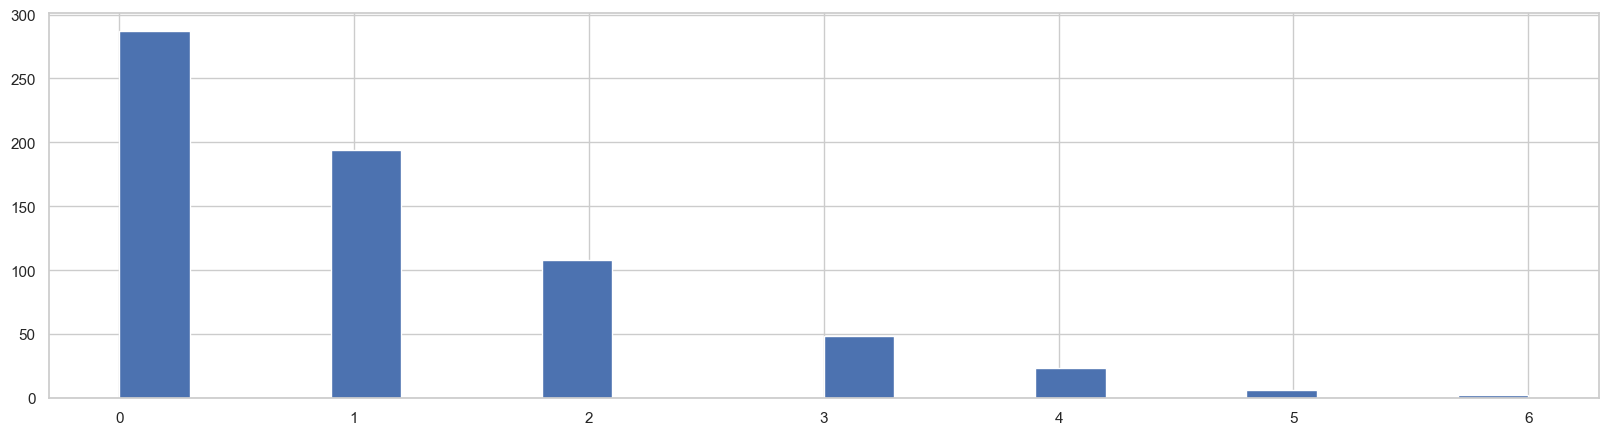

In [42]:
# calculating average overlap
overlap= []
num_rec = []
n = 20
for user in ratings.userId.unique():
    top_items = model.topN(user = user, n = n)
    user_movies = ratings.loc[(ratings.userId == user)].movieId
    valid_rec = set(top_items).intersection(set(user_movies)) # measurement can only be done by what was in the training data

    _ = len(set(ratings.loc[ratings.userId == user].sort_values(by = "rating", ascending = False).head(n).movieId).intersection(set(valid_rec)))
    overlap.append(_)
    num_rec.append(len(valid_rec))

print("avg_perc_overlap: ", np.array(overlap).mean() /np.array(num_rec).mean())
pd.Series(overlap).hist(bins = 20)

### What is K-Precision?
- K-Precision is a metric used to evaluate the quality of recommendations provided by recommendation systems.
- It assesses how many of the top K recommended items are relevant to the user's preferences.
- A higher K-Precision value indicated better recommendation quality.

$\text{K-Precision} = \frac{\sum{\text{Relevant items in top K recommendations}}}{\sum{\text{Items in top K recommendations}}}$

avg: 0.7849889642782759


<Axes: >

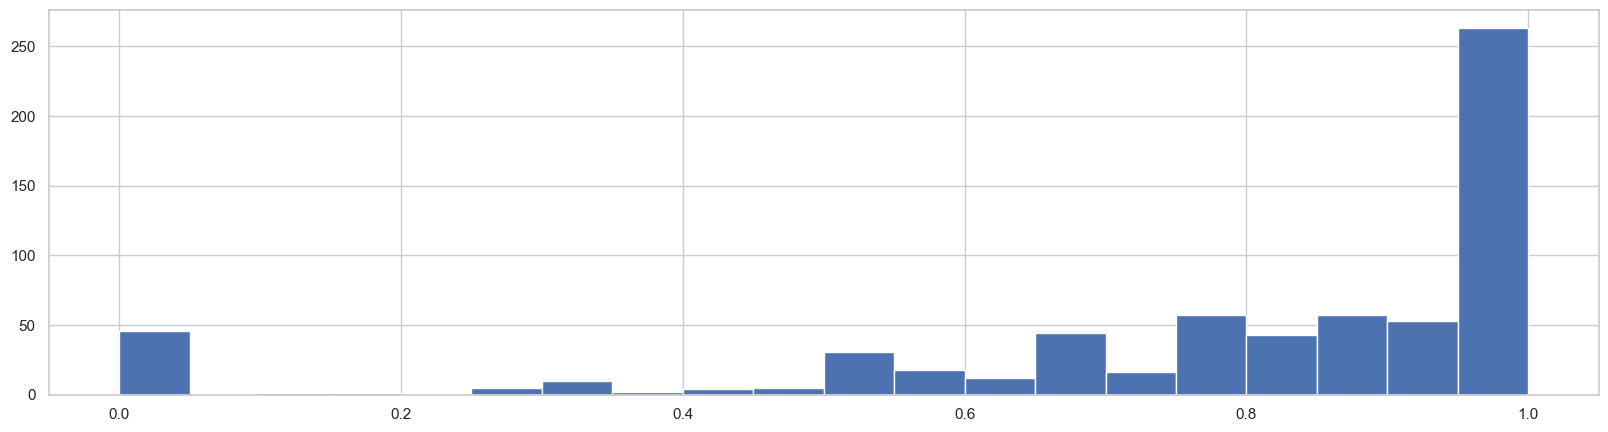

In [43]:
# how many of the K predictions were relevant
overlap=[]
for user in ratings.userId.unique():
    recommendations = model.topN(user = user, n = 100)
    user_movies = ratings.loc[(ratings.userId == user)].movieId
    valid_rec = set(recommendations).intersection(set(user_movies)) # I can only measure by what was in the training data
    relevant_items = ratings.loc[(ratings.userId == user) & (ratings.rating >= 4)].movieId
    try:
        _ = len(set(recommendations).intersection(set(relevant_items)))/ len(valid_rec)
    except:
        _ = 0
    overlap.append(_)

overlap = np.array(overlap)
print('avg:', overlap.mean())
pd.Series(overlap).hist(bins = 20)

# this code is essentially computing the precision

avg: 0.21475637378786894


<Axes: >

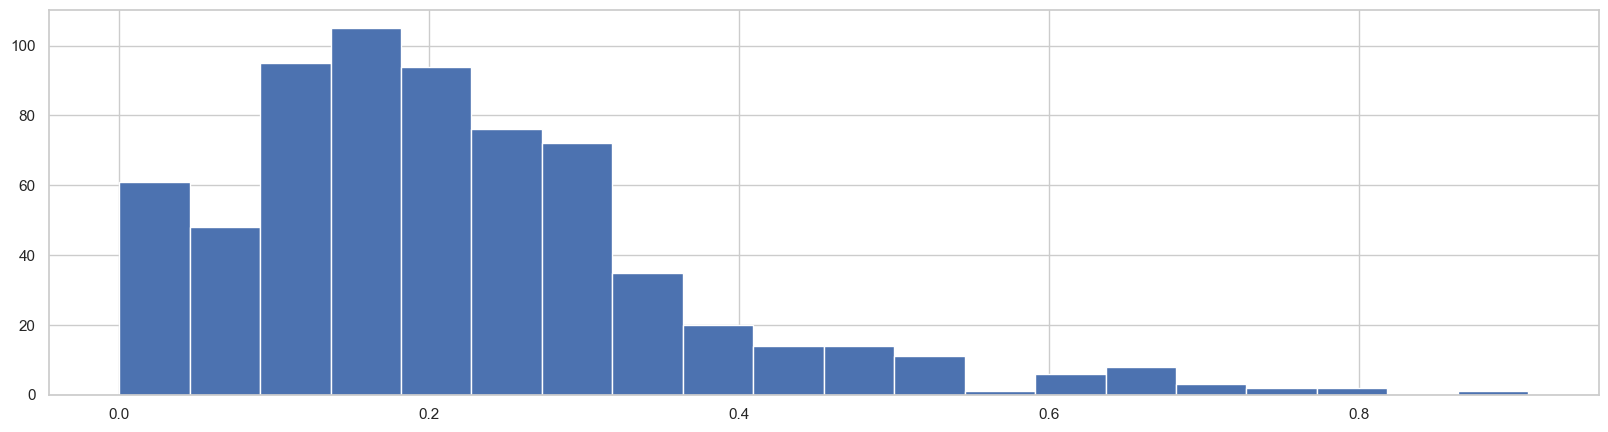

In [44]:
# how many of the K predictions were relevant and found correctly
overlap=[]
for user in ratings.userId.unique():
    recommendations = model.topN(user = user, n = 100)
    user_movies = ratings.loc[(ratings.userId == user)].movieId
    valid_rec = set(recommendations).intersection(set(user_movies)) # I can only measure by what was in the training data
    relevant_items = ratings.loc[(ratings.userId == user) & (ratings.rating >= 4)].movieId
    try:
        _ = len(set(recommendations).intersection(set(relevant_items)))/ len(set(relevant_items))
    except:
        _ = 0
    overlap.append(_)

overlap = np.array(overlap)
print('avg:', overlap.mean())
pd.Series(overlap).hist(bins = 20)

# this code is essentially computing the recall